# Hyperelastic heterogeneous material

In this demo, we show how to define a problem containing a call to a MFront behavior on a subset of cells while defining the behavior on the remaining part of the domain using UFL.

```{tip}
This demo also works in parallel.
```

We consider a unit square consisting of circular inclusions of radius $R=0.4$ located at the 8 vertices of the unit cube. The matrix domain $\Omega_\text{m}$ (tagged `1`) consists of a Ogden hyperelastic material implemented with MFront. The inclusions domain $\Omega_\text{i}$ (tagged `2`) is assumed to be much stiffer and will be described by a Saint-Venant Kirchhoff (SVK) material of modulus $E_\text{pen} = 10^3$ GPa and Poisson ratio $\nu=0$. This behavior will be implemented in pure UFL.

```{image} hyperelasticity.gif
:align: center
:width: 500px
```

## Meshing

We start by importing the relevant modules and defining the geometrical characteristics.

In [1]:
import numpy as np
from mpi4py import MPI
import gmsh
import ufl
from petsc4py import PETSc
from dolfinx import fem, io
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.mfront import MFrontMaterial
from dolfinx_materials.solvers import NonlinearMaterialProblem
from dolfinx_materials.utils import (
    symmetric_tensor_to_vector,
    nonsymmetric_tensor_to_vector,
)

comm = MPI.COMM_WORLD
rank = comm.rank

dim = 3
L = 1.0
R = 0.4
hsize = 0.1

centers = np.array(
    [
        [0.0, 0.0, 0.0],
        [L, 0.0, 0.0],
        [0.0, L, 0.0],
        [0.0, 0.0, L],
        [L, L, 0.0],
        [L, 0.0, L],
        [0.0, L, L],
        [L, L, L],
    ]
)

We then define the mesh using `gmsh`.

In [2]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info

if rank == 0:
    rectangle = gmsh.model.occ.addBox(0, 0, 0, L, L, L)
    inclusions = []
    for c in centers:
        inclusion = gmsh.model.occ.addSphere(*c, R)
        inclusions.append(inclusion)
    vol_dimTag = (dim, rectangle)
    out = gmsh.model.occ.intersect(
        [vol_dimTag], [(dim, incl) for incl in inclusions], removeObject=False
    )
    incl_dimTags = out[0]
    gmsh.model.occ.synchronize()
    gmsh.model.occ.cut([vol_dimTag], incl_dimTags, removeTool=False)
    gmsh.model.occ.synchronize()

    gmsh.model.addPhysicalGroup(dim, [vol_dimTag[1]], 1, name="Matrix")
    gmsh.model.addPhysicalGroup(
        dim, [tag for (d, tag) in incl_dimTags], 2, name="Inclusions"
    )
    eps = 1e-3 * L
    left = gmsh.model.getEntitiesInBoundingBox(
        -eps, -eps, -eps, eps, L + eps, L + eps, dim=dim - 1
    )

    right = gmsh.model.getEntitiesInBoundingBox(
        L - eps, -eps, -eps, L + eps, L + eps, L + eps, dim=dim - 1
    )
    gmsh.model.addPhysicalGroup(dim - 1, [tag for (d, tag) in left], 1, name="Left")
    gmsh.model.addPhysicalGroup(dim - 1, [tag for (d, tag) in right], 2, name="Right")

    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize)

    gmsh.model.mesh.generate(dim)

mesh_data = io.gmsh.model_to_mesh(gmsh.model, comm, 0)
subdomains = mesh_data.cell_tags
facets = mesh_data.facet_tags
domain = mesh_data.mesh
gmsh.finalize()

## Problem position

Next, we define fixed displacement boundary conditions on the left boundary and will impose a uniform horizontal displacement on the right surface. For this problem, we use $\mathbb{P}_2$ Lagrange elements and a quadrature rule degree of 2.

In [3]:
fdim = dim - 1
domain.topology.create_connectivity(fdim, dim)

order = 2
V = fem.functionspace(domain, ("P", order, (3,)))
deg_quad = 2 * (order - 1)

left_dofs = fem.locate_dofs_topological(V, fdim, facets.find(1))
right_dofs = fem.locate_dofs_topological(V, fdim, facets.find(2))


uD = fem.Constant(domain, np.zeros((dim,)))
bcs = [
    fem.dirichletbc(np.zeros((dim,)), left_dofs, V),
    fem.dirichletbc(uD, right_dofs, V),
]

The weak form writes in the present case as follows:

$$
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\dOm}{\,\text{d}\Omega}
\int_{\Omega_\text{m}}\boldsymbol{P}(\bu):\nabla\bv \dOm + \int_{\Omega_\text{i}}\boldsymbol{S}(\bu):\delta\be_\text{GL}(\bu;\bv) \dOm = 0 \quad \forall\bv\in V
$$
where $\boldsymbol{P}(\bu)$ denotes the matrix first Piola-Kirchhoff stress obtained from the MFront Ogden material, $\boldsymbol{S}(\bu) = E_\text{pen}\be_\text{GL}(\bu)$ denotes the second Piola-Kirchhoff stress associated with the quasi-rigid SVK material, $\be_\text{GL}(\bu)$ is the Green-Lagrange strain and $\delta\be_\text{GL}(\bu;\bv)$ its variation in direction $\bv$.

We define below helper functions for implementing the weak form. Note that we use the `symmetric_tensor_to_vector` and `nonsymmetric_tensor_to_vector` functions from `dolfinx_material.utils` to convert tensors to vectorial representation following [](tensors_conventions). We first implement the inclusions contribution to the total residual weak form using pure UFL.

In [4]:
Id = ufl.Identity(dim)


def GL_strain(u):
    F = Id + ufl.grad(u)
    eGL = (F.T * F - Id) / 2
    return symmetric_tensor_to_vector(eGL)


def dGL_strain(u, v):
    return ufl.derivative(GL_strain(u), u, v)


def F(u):
    return nonsymmetric_tensor_to_vector(Id + ufl.grad(u))


def dF(u, v):
    return ufl.derivative(F(u), u, v)


du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
u = fem.Function(V, name="Displacement")

dx = ufl.dx(subdomain_data=subdomains)

E_pen = fem.Constant(domain, 1e12)
Res_inclusions = ufl.dot(E_pen * GL_strain(u), dGL_strain(u, v)) * dx(2)

Second, we define the Ogden `MFrontMaterial` instance and implement the matrix contribution to the weak form residual. Note that we enforce `cells=cells_matrix`, asking the `QuadratureMap` to call the constitutive update only at quadrature points located within these matrix cells.

In [5]:
material = MFrontMaterial(
    "src/libBehaviour.so",
    "Ogden",
)

cells_matrix = subdomains.find(1)
qmap = QuadratureMap(domain, deg_quad, material, cells=cells_matrix)
qmap.register_gradient("DeformationGradient", F(u))
qmap.dx = qmap.dx(subdomain_data=subdomains)

PK1 = qmap.fluxes["FirstPiolaKirchhoffStress"]
Res_matrix = ufl.dot(PK1, dF(u, v)) * dx(1)

Finally, the total residual is the sum of both residuals. We also include a normalizing factor since all stress quantities are expressed in Pa units.

In [6]:
normalization_factor = fem.Constant(domain, 1e-6)
Res = normalization_factor * (Res_matrix + Res_inclusions)
Jac = qmap.derivative(Res, u, du)

## Resolution

Next, we define the custom nonlinear problem, the corresponding Newton solver and the PETSc Krylov solver used to solve the linear systems within Newton's method. We use here a GMRES iterative solver preconditioned with a Geometric Algebraic MultiGrid preconditioner.

In [7]:
petsc_options = {
    "snes_type": "newtonls",
    "snes_linesearch_type": "none",
    "snes_atol": 1e-8,
    "snes_rtol": 1e-8,
    "snes_monitor": None,
    "ksp_type": "gmres",
    "ksp_rtol": 1e-8,
    "pc_type": "gamg",
}
problem = NonlinearMaterialProblem(
    qmap,
    Res,
    u,
    bcs=bcs,
    J=Jac,
    petsc_options_prefix="hyperelasticity",
    petsc_options=petsc_options,
)

In [8]:
file_results = io.VTKFile(
    domain.comm,
    f"{material.name}_results.pvd",
    "w",
)

N = 10
Exx = np.linspace(0, 20e-2, N + 1)

file_results.write_function(u, 0)
for i, exx in enumerate(Exx[1:]):
    uD.value[0] = exx * L

    if rank == 0:
        print(f"Increment {i}")

    problem.solve()

    file_results.write_function(u, i + 1)


file_results.close()

Increment 0
  0 SNES Function norm 2.023012265669e+04
  1 SNES Function norm 3.548372354705e-02
  2 SNES Function norm 4.300758649488e-03
  3 SNES Function norm 6.332286793605e-04
  4 SNES Function norm 6.628367239322e-06
Increment 1
  0 SNES Function norm 2.023013501112e+04
  1 SNES Function norm 6.569648379669e-02
  2 SNES Function norm 5.882538690243e-03
  3 SNES Function norm 1.212648470645e-03
  4 SNES Function norm 1.126446646361e-05
Increment 2
  0 SNES Function norm 2.023018133697e+04
  1 SNES Function norm 1.475287382480e-01
  2 SNES Function norm 1.392339845861e-02
  3 SNES Function norm 2.907242602503e-03
  4 SNES Function norm 8.678865793544e-05
Increment 3
  0 SNES Function norm 2.023032240898e+04
  1 SNES Function norm 1.909428495219e-01
  2 SNES Function norm 1.247842975044e-02
  3 SNES Function norm 1.829753746768e-04
Increment 4
  0 SNES Function norm 2.023061901361e+04
  1 SNES Function norm 2.275894736059e-01
  2 SNES Function norm 9.749103040106e-03
  3 SNES Functio

## Timings

We list the total timings by gathering all times spent on each rank and compute the average per rank. We can check that the constitutive update represents only a small fraction of the total computing time which is mostly dominated by the cost of solving the global linear system at each global Newton iteration.

In [9]:
from dolfinx.common import timing

constitutive_update_time = timing("SNES: constitutive update")[1].total_seconds()
snes_solve_time = timing("SNES: solve")[1].total_seconds()

# Gather all times on rank 0
all_times = None
if rank == 0:
    all_times = np.zeros((comm.size, 2))
comm.Gather(np.array([constitutive_update_time, snes_solve_time]), all_times, root=0)

# Compute the average time on rank 0
if rank == 0:
    average_time = np.mean(all_times, axis=0)
    print(f"Average total time spent in constitutive update {average_time[0]:.2f}s")
    print(f"Average time spent in global solver {average_time[1]:.2f}s")

Average total time spent in constitutive update 0.94s
Average time spent in global solver 106.51s


The figure below represents a very basic scaling study from 1 to 8 ranks for two different mesh sizes.

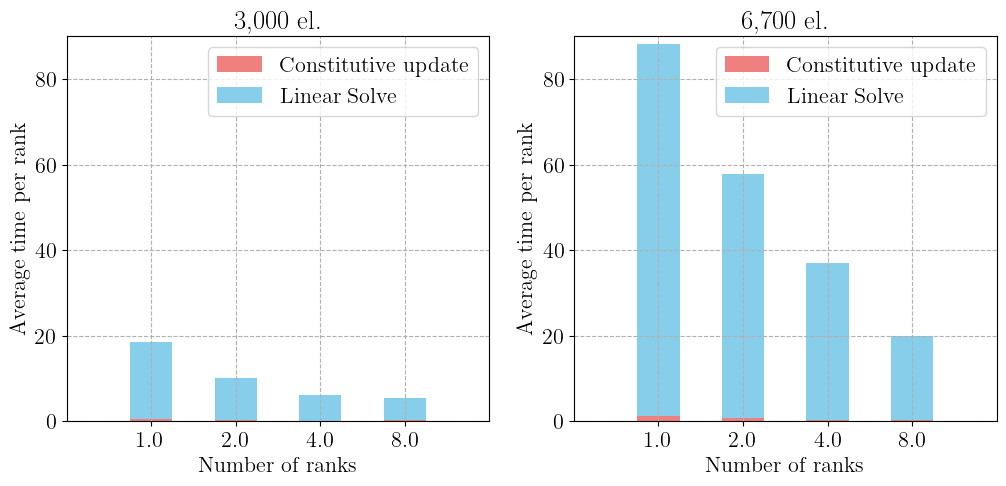

In [ ]:
import matplotlib.pyplot as plt

data = np.loadtxt("timing_results.csv", delimiter=",", skiprows=2)
ranks = data[:, 0]
x = np.arange(len(ranks), dtype=int)
bar_width = 0.5

plt.figure(figsize=(12, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)

    y1 = data[:, 2 * i + 1]
    y2 = data[:, 2 * i + 2]
    plt.bar(x, y1, bar_width, label="Constitutive update", color="lightcoral")
    plt.bar(x, y2, bar_width, bottom=y1, label="Linear solve", color="skyblue")

    plt.xlabel("Number of ranks")
    plt.ylabel("Average time per rank")
    plt.xticks(x, ranks)
    plt.ylim(0, 90)
    plt.title({0: "3,000 el.", 1: "6,700 el."}[i])
    plt.legend()

# Show plot
plt.show()